,subject,timepoint,biomarker_0,biomarker_1,biomarker_2,biomarker_3,biomarker_4
0,0,0.000000,0.885888,0.647173,0.398673,1.130997,1.058619
1,1,0.000000,-0.033489,-0.052632,-0.045887,0.842935,0.738897
2,2,0.000000,0.096386,0.107866,0.043484,0.519497,0.711044
3,2,0.453224,0.153048,0.063080,0.205047,0.964920,1.079642
4,2,0.704842,0.773720,0.463185,0.535985,1.004168,1.086914
...,...,...,...,...,...,...,...
96,47,0.041061,0.541035,0.024848,0.285013,1.069036,0.983759
97,48,0.000000,0.824434,0.305255,0.192245,1.064016,0.959622
98,49,0.000000,0.000413,0.042853,0.121324,0.758250,0.996377
99,49,0.053054,-0.009946,0.021269,0.062708,0.892050,0.772699


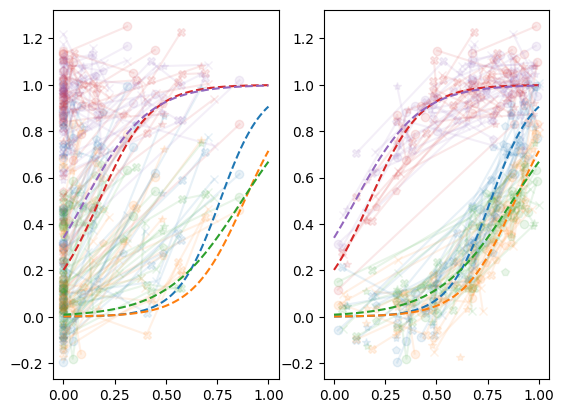

In [1]:
import json
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

np.set_printoptions(precision=3, suppress=True)

N_ROUNDS = 10
N_UPDATES = 70
BATCH_SIZE = 100000
LEARNING_RATE = 0.01

data_dir = Path(os.environ["DPATH_DATA"])

json_data = json.loads((data_dir / "simulated_data.json").read_text())

n_biomarkers = json_data["settings"]["n_biomarkers"]
params = json_data["params"]
k_values = np.array(params["k_values"])
x0_values = np.array(params["x0_values"])
time_shifts = np.array(params["time_shifts"])

df = pd.read_csv(data_dir / "simulated_data.tsv", sep="\t")
display(df)

fig, axes = plt.subplots(ncols=2)
for i_ax, ax in enumerate(axes):
    ax: plt.Axes

    for i_subject, (subject, df_subject) in enumerate(df.groupby("subject")):
        for i_biomarker, biomarker in enumerate(
            [f"biomarker_{i}" for i in range(n_biomarkers)]
        ):
            ax.plot(
                (
                    df_subject["timepoint"] + time_shifts[i_subject]
                    if i_ax == 1
                    else df_subject["timepoint"]
                ),
                df_subject[biomarker],
                marker="oXxp*"[i_subject % 5],
                color=f"C{i_biomarker}",
                alpha=0.1,
            )

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):
        t = np.linspace(0, 1, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=1)


def check_model_fit(
    estimated_k_values, estimated_x0_values, estimated_time_shifts, align_x=False
):
    _, ax = plt.subplots()
    ax: plt.Axes

    x_value_differences = x0_values - estimated_x0_values

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):
        t = np.linspace(-1, 2, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=0.8)

        y_pred = torch.sigmoid(
            torch.tensor(
                estimated_k_values[i_biomarker] * (t - estimated_x0_values[i_biomarker])
            )
        ).numpy()
        ax.plot(
            t + x_value_differences[i_biomarker] if align_x else t,
            y_pred,
            color=f"C{i_biomarker}",
            linestyle="-",
            alpha=0.8,
        )

    print("===== k values =====")
    print(k_values)
    print(estimated_k_values)
    print("===== x0 values =====")
    print(x0_values)
    print(estimated_x0_values)
    print("===== x value differences =====")
    print(x0_values - estimated_x0_values)
    print("===== time shifts =====")
    print(time_shifts)
    print(estimated_time_shifts)
    if len(estimated_time_shifts) > 0:
        print("===== time shift offset difference =====")
        if len(time_shifts) < len(estimated_time_shifts):
            warnings.warn(
                "Number of estimated time shifts is larger than the number of true time "
                "shifts. Clipping estimated time shifts."
            )
            estimated_time_shifts = estimated_time_shifts[: len(time_shifts)]

        print((time_shifts - estimated_time_shifts).std())

In [2]:
from fl_prog.utils.io import working_directory
from fl_prog.training_plan import FLProgTrainingPlan
from fl_prog.aggregator import SelectiveFedAverage

import importlib
import fl_prog.training_plan

importlib.reload(fl_prog.training_plan)
from fl_prog.training_plan import FLProgTrainingPlan


fedbiomed_dir = "../fedbiomed"
with working_directory(fedbiomed_dir):

    from fedbiomed.researcher.federated_workflows import Experiment
    from fedbiomed.researcher.aggregators.fedavg import FedAverage

    experiment = Experiment(
        nodes=["NODE_CENTRALIZED"],
        tags=["CENTRALIZED"],
        training_plan_class=FLProgTrainingPlan,
        model_args={
            "colnames": {
                "col_subject_id": "subject",
                "col_time": "timepoint",
                "cols_biomarker": [f"biomarker_{i}" for i in range(n_biomarkers)],
            },
            "lr_with_shift": {
                "n_features": n_biomarkers,
            },
        },
        round_limit=N_ROUNDS,
        training_args={
            "num_updates": N_UPDATES,
            "loader_args": {"batch_size": BATCH_SIZE, "shuffle": False},
            "optimizer_args": {"lr": LEARNING_RATE},
        },
        aggregator=SelectiveFedAverage(["time_shifts"]),
        node_selection_strategy=None,
    )
    experiment.run()

/home/bic/mwang/projects/fl-prog/.venv/lib/python3.10/site-packages/monai/utils/module.py:367: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


2025-10-10 10:47:35,961 fedbiomed INFO - Starting researcher service...

2025-10-10 10:47:35,963 fedbiomed INFO - Waiting 3s for nodes to connect...

2025-10-10 10:47:36,786 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:38,970 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2025-10-10 10:47:38,976 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:38,988 fedbiomed INFO - Node selected for training -> NODE_CENTRALIZED

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:39,027 fedbiomed DEBUG - Model file has been saved: /data/origami/michelle/projects/fl-prog/fedbiomed/fbm-researcher/var/experiments/Experiment_0116/model_6674dfac-f79f-456d-9f5b-fa100b495668.py

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.


2025-10-10 10:47:39,432 fedbiomed INFO - Sampled nodes in round 0 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:39,456 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:39,531 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:39,784 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 491.425934 
					 ---------

2025-10-10 10:47:39,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 488.879822 
					 ---------

2025-10-10 10:47:39,809 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 486.336151 
					 ---------

2025-10-10 10:47:39,825 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 483.794830 
					 ---------

2025-10-10 10:47:39,841 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 481.255829 
					 ---------

2025-10-10 10:47:39,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 478.719086 
					 ---------

2025-10-10 10:47:39,874 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 476.184631 
					 ---------

2025-10-10 10:47:39,892 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 473.652527 
					 ---------

2025-10-10 10:47:39,908 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 471.122681 
					 ---------

2025-10-10 10:47:39,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 468.595123 
					 ---------

2025-10-10 10:47:39,941 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 466.069794 
					 ---------

2025-10-10 10:47:39,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 463.546600 
					 ---------

2025-10-10 10:47:39,972 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 461.025482 
					 ---------

2025-10-10 10:47:39,991 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 458.506287 
					 ---------

2025-10-10 10:47:40,007 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 455.988922 
					 ---------

2025-10-10 10:47:40,022 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 453.473206 
					 ---------

2025-10-10 10:47:40,039 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 450.958984 
					 ---------

2025-10-10 10:47:40,055 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 448.446014 
					 ---------

2025-10-10 10:47:40,071 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 445.934143 
					 ---------

2025-10-10 10:47:40,087 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 443.422974 
					 ---------

2025-10-10 10:47:40,104 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 440.912292 
					 ---------

2025-10-10 10:47:40,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 438.401794 
					 ---------

2025-10-10 10:47:40,136 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 435.891052 
					 ---------

2025-10-10 10:47:40,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 433.379669 
					 ---------

2025-10-10 10:47:40,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 430.867432 
					 ---------

2025-10-10 10:47:40,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 428.353760 
					 ---------

2025-10-10 10:47:40,201 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 425.838165 
					 ---------

2025-10-10 10:47:40,218 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 423.320312 
					 ---------

2025-10-10 10:47:40,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 420.799683 
					 ---------

2025-10-10 10:47:40,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 418.275787 
					 ---------

2025-10-10 10:47:40,267 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 415.748230 
					 ---------

2025-10-10 10:47:40,283 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 413.216461 
					 ---------

2025-10-10 10:47:40,299 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 410.680084 
					 ---------

2025-10-10 10:47:40,315 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 408.138733 
					 ---------

2025-10-10 10:47:40,331 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 405.591949 
					 ---------

2025-10-10 10:47:40,349 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 403.039215 
					 ---------

2025-10-10 10:47:40,365 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 400.480469 
					 ---------

2025-10-10 10:47:40,381 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 397.915344 
					 ---------

2025-10-10 10:47:40,398 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 395.343628 
					 ---------

2025-10-10 10:47:40,418 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 392.765198 
					 ---------

2025-10-10 10:47:40,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 390.179993 
					 ---------

2025-10-10 10:47:40,453 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 387.588165 
					 ---------

2025-10-10 10:47:40,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 384.989868 
					 ---------

2025-10-10 10:47:40,486 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 382.385406 
					 ---------

2025-10-10 10:47:40,502 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 379.775299 
					 ---------

2025-10-10 10:47:40,519 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 377.160095 
					 ---------

2025-10-10 10:47:40,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 374.540405 
					 ---------

2025-10-10 10:47:40,552 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 371.917297 
					 ---------

2025-10-10 10:47:40,568 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 369.291565 
					 ---------

2025-10-10 10:47:40,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 366.664337 
					 ---------

2025-10-10 10:47:40,605 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 364.036560 
					 ---------

2025-10-10 10:47:40,622 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 361.409302 
					 ---------

2025-10-10 10:47:40,639 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: 358.783600 
					 ---------

2025-10-10 10:47:40,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: 356.160004 
					 ---------

2025-10-10 10:47:40,676 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: 353.538879 
					 ---------

2025-10-10 10:47:40,693 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: 350.920532 
					 ---------

2025-10-10 10:47:40,709 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: 348.304504 
					 ---------

2025-10-10 10:47:40,733 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: 345.689819 
					 ---------

2025-10-10 10:47:40,753 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: 343.075500 
					 ---------

2025-10-10 10:47:40,774 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: 340.460388 
					 ---------

2025-10-10 10:47:40,793 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: 337.843506 
					 ---------

2025-10-10 10:47:40,812 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: 335.223694 
					 ---------

2025-10-10 10:47:40,832 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: 332.600403 
					 ---------

2025-10-10 10:47:40,851 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: 329.973328 
					 ---------

2025-10-10 10:47:40,871 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: 327.342926 
					 ---------

2025-10-10 10:47:40,889 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: 324.709900 
					 ---------

2025-10-10 10:47:40,908 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: 322.074493 
					 ---------

2025-10-10 10:47:40,926 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: 319.437622 
					 ---------

2025-10-10 10:47:40,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: 316.800507 
					 ---------

2025-10-10 10:47:40,962 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 1 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: 314.163666 
					 ---------

2025-10-10 10:47:41,080 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_CENTRALIZED']

2025-10-10 10:47:41,113 fedbiomed INFO - Sampled nodes in round 1 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:41,173 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:41,284 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:41,419 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 311.527863 
					 ---------

2025-10-10 10:47:41,447 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 308.952423 
					 ---------

2025-10-10 10:47:41,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 306.382233 
					 ---------

2025-10-10 10:47:41,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 303.817322 
					 ---------

2025-10-10 10:47:41,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 301.256348 
					 ---------

2025-10-10 10:47:41,521 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 298.698212 
					 ---------

2025-10-10 10:47:41,538 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 296.141357 
					 ---------

2025-10-10 10:47:41,555 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 293.584747 
					 ---------

2025-10-10 10:47:41,571 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 291.027954 
					 ---------

2025-10-10 10:47:41,588 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 288.470673 
					 ---------

2025-10-10 10:47:41,606 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 285.912659 
					 ---------

2025-10-10 10:47:41,622 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 283.354187 
					 ---------

2025-10-10 10:47:41,638 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 280.795624 
					 ---------

2025-10-10 10:47:41,654 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 278.237091 
					 ---------

2025-10-10 10:47:41,671 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 275.678772 
					 ---------

2025-10-10 10:47:41,687 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 273.120789 
					 ---------

2025-10-10 10:47:41,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 270.563110 
					 ---------

2025-10-10 10:47:41,720 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 268.005890 
					 ---------

2025-10-10 10:47:41,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 265.449066 
					 ---------

2025-10-10 10:47:41,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 262.892731 
					 ---------

2025-10-10 10:47:41,769 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 260.337158 
					 ---------

2025-10-10 10:47:41,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 257.782471 
					 ---------

2025-10-10 10:47:41,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 255.229401 
					 ---------

2025-10-10 10:47:41,817 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 252.677658 
					 ---------

2025-10-10 10:47:41,834 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 250.127228 
					 ---------

2025-10-10 10:47:41,849 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 247.578049 
					 ---------

2025-10-10 10:47:41,865 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 245.030121 
					 ---------

2025-10-10 10:47:41,881 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 242.483383 
					 ---------

2025-10-10 10:47:41,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 239.937683 
					 ---------

2025-10-10 10:47:41,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 237.392761 
					 ---------

2025-10-10 10:47:41,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 234.848587 
					 ---------

2025-10-10 10:47:41,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 232.304901 
					 ---------

2025-10-10 10:47:41,961 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 229.761566 
					 ---------

2025-10-10 10:47:41,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 227.218445 
					 ---------

2025-10-10 10:47:41,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 224.675186 
					 ---------

2025-10-10 10:47:42,009 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 222.131683 
					 ---------

2025-10-10 10:47:42,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 219.587784 
					 ---------

2025-10-10 10:47:42,041 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 217.043457 
					 ---------

2025-10-10 10:47:42,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 214.498688 
					 ---------

2025-10-10 10:47:42,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 211.953415 
					 ---------

2025-10-10 10:47:42,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 209.407684 
					 ---------

2025-10-10 10:47:42,106 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 206.861496 
					 ---------

2025-10-10 10:47:42,124 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 204.314957 
					 ---------

2025-10-10 10:47:42,140 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 201.768158 
					 ---------

2025-10-10 10:47:42,160 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 199.221344 
					 ---------

2025-10-10 10:47:42,177 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 196.674667 
					 ---------

2025-10-10 10:47:42,193 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 194.128418 
					 ---------

2025-10-10 10:47:42,209 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 191.582901 
					 ---------

2025-10-10 10:47:42,226 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 189.038422 
					 ---------

2025-10-10 10:47:42,243 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 186.495453 
					 ---------

2025-10-10 10:47:42,261 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 183.954239 
					 ---------

2025-10-10 10:47:42,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 181.415207 
					 ---------

2025-10-10 10:47:42,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: 178.878754 
					 ---------

2025-10-10 10:47:42,316 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: 176.345215 
					 ---------

2025-10-10 10:47:42,332 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: 173.814941 
					 ---------

2025-10-10 10:47:42,352 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: 171.288391 
					 ---------

2025-10-10 10:47:42,368 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: 168.765762 
					 ---------

2025-10-10 10:47:42,385 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: 166.247421 
					 ---------

2025-10-10 10:47:42,401 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: 163.733688 
					 ---------

2025-10-10 10:47:42,416 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: 161.224838 
					 ---------

2025-10-10 10:47:42,432 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: 158.721161 
					 ---------

2025-10-10 10:47:42,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: 156.222961 
					 ---------

2025-10-10 10:47:42,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: 153.730469 
					 ---------

2025-10-10 10:47:42,479 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: 151.244019 
					 ---------

2025-10-10 10:47:42,495 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: 148.763763 
					 ---------

2025-10-10 10:47:42,510 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: 146.289963 
					 ---------

2025-10-10 10:47:42,527 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: 143.822769 
					 ---------

2025-10-10 10:47:42,543 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: 141.362366 
					 ---------

2025-10-10 10:47:42,559 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: 138.908905 
					 ---------

2025-10-10 10:47:42,576 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 2 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: 136.462509 
					 ---------

2025-10-10 10:47:42,719 fedbiomed INFO - Nodes that successfully reply in round 1 ['NODE_CENTRALIZED']

2025-10-10 10:47:42,749 fedbiomed INFO - Sampled nodes in round 2 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:42,773 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:42,834 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:42,918 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: 134.023285 
					 ---------

2025-10-10 10:47:42,933 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: 131.587143 
					 ---------

2025-10-10 10:47:42,949 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: 129.148590 
					 ---------

2025-10-10 10:47:42,967 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: 126.722633 
					 ---------

2025-10-10 10:47:42,983 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: 124.301697 
					 ---------

2025-10-10 10:47:42,998 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: 121.883720 
					 ---------

2025-10-10 10:47:43,014 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: 119.471611 
					 ---------

2025-10-10 10:47:43,030 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: 117.067123 
					 ---------

2025-10-10 10:47:43,045 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: 114.668976 
					 ---------

2025-10-10 10:47:43,061 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: 112.275383 
					 ---------

2025-10-10 10:47:43,077 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: 109.885735 
					 ---------

2025-10-10 10:47:43,093 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: 107.499710 
					 ---------

2025-10-10 10:47:43,109 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: 105.117393 
					 ---------

2025-10-10 10:47:43,124 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: 102.738998 
					 ---------

2025-10-10 10:47:43,141 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: 100.364410 
					 ---------

2025-10-10 10:47:43,156 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: 97.993317 
					 ---------

2025-10-10 10:47:43,172 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: 95.625366 
					 ---------

2025-10-10 10:47:43,187 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: 93.260117 
					 ---------

2025-10-10 10:47:43,203 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: 90.897476 
					 ---------

2025-10-10 10:47:43,219 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: 88.537392 
					 ---------

2025-10-10 10:47:43,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: 86.179169 
					 ---------

2025-10-10 10:47:43,250 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: 83.822334 
					 ---------

2025-10-10 10:47:43,266 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: 81.466461 
					 ---------

2025-10-10 10:47:43,281 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: 79.111023 
					 ---------

2025-10-10 10:47:43,297 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: 76.755707 
					 ---------

2025-10-10 10:47:43,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: 74.400116 
					 ---------

2025-10-10 10:47:43,329 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: 72.043953 
					 ---------

2025-10-10 10:47:43,344 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: 69.686928 
					 ---------

2025-10-10 10:47:43,360 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: 67.329018 
					 ---------

2025-10-10 10:47:43,375 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: 64.970085 
					 ---------

2025-10-10 10:47:43,392 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: 62.610142 
					 ---------

2025-10-10 10:47:43,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: 60.249165 
					 ---------

2025-10-10 10:47:43,423 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: 57.887142 
					 ---------

2025-10-10 10:47:43,439 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: 55.524059 
					 ---------

2025-10-10 10:47:43,455 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: 53.159874 
					 ---------

2025-10-10 10:47:43,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: 50.794567 
					 ---------

2025-10-10 10:47:43,486 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: 48.428024 
					 ---------

2025-10-10 10:47:43,502 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: 46.060192 
					 ---------

2025-10-10 10:47:43,518 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: 43.690979 
					 ---------

2025-10-10 10:47:43,534 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: 41.320259 
					 ---------

2025-10-10 10:47:43,549 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: 38.947861 
					 ---------

2025-10-10 10:47:43,565 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: 36.573696 
					 ---------

2025-10-10 10:47:43,581 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: 34.197552 
					 ---------

2025-10-10 10:47:43,596 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: 31.819216 
					 ---------

2025-10-10 10:47:43,612 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: 29.438562 
					 ---------

2025-10-10 10:47:43,627 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: 27.055441 
					 ---------

2025-10-10 10:47:43,643 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: 24.669750 
					 ---------

2025-10-10 10:47:43,659 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: 22.281338 
					 ---------

2025-10-10 10:47:43,675 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: 19.890150 
					 ---------

2025-10-10 10:47:43,690 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: 17.496038 
					 ---------

2025-10-10 10:47:43,706 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: 15.099062 
					 ---------

2025-10-10 10:47:43,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: 12.698998 
					 ---------

2025-10-10 10:47:43,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: 10.295980 
					 ---------

2025-10-10 10:47:43,754 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: 7.889885 
					 ---------

2025-10-10 10:47:43,770 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: 5.480724 
					 ---------

2025-10-10 10:47:43,786 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: 3.068433 
					 ---------

2025-10-10 10:47:43,802 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: 0.652978 
					 ---------

2025-10-10 10:47:43,819 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -1.765457 
					 ---------

2025-10-10 10:47:43,834 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -4.186835 
					 ---------

2025-10-10 10:47:43,851 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -6.611526 
					 ---------

2025-10-10 10:47:43,866 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -9.040521 
					 ---------

2025-10-10 10:47:43,881 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -11.471883 
					 ---------

2025-10-10 10:47:43,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -13.905571 
					 ---------

2025-10-10 10:47:43,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -16.343454 
					 ---------

2025-10-10 10:47:43,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -18.783909 
					 ---------

2025-10-10 10:47:43,944 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -21.226398 
					 ---------

2025-10-10 10:47:43,960 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -23.672232 
					 ---------

2025-10-10 10:47:43,976 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -26.120867 
					 ---------

2025-10-10 10:47:44,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -28.571196 
					 ---------

2025-10-10 10:47:44,015 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 3 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -31.023949 
					 ---------

2025-10-10 10:47:44,233 fedbiomed INFO - Nodes that successfully reply in round 2 ['NODE_CENTRALIZED']

2025-10-10 10:47:44,391 fedbiomed INFO - Sampled nodes in round 3 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:44,433 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:44,550 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:44,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -33.479546 
					 ---------

2025-10-10 10:47:44,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -35.794289 
					 ---------

2025-10-10 10:47:44,708 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -38.269699 
					 ---------

2025-10-10 10:47:44,727 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -40.666088 
					 ---------

2025-10-10 10:47:44,743 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -43.044376 
					 ---------

2025-10-10 10:47:44,758 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -45.452126 
					 ---------

2025-10-10 10:47:44,775 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -47.871788 
					 ---------

2025-10-10 10:47:44,791 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -50.279114 
					 ---------

2025-10-10 10:47:44,807 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -52.676418 
					 ---------

2025-10-10 10:47:44,822 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -55.083035 
					 ---------

2025-10-10 10:47:44,837 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -57.496399 
					 ---------

2025-10-10 10:47:44,853 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -59.903816 
					 ---------

2025-10-10 10:47:44,869 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -62.304756 
					 ---------

2025-10-10 10:47:44,885 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -64.708954 
					 ---------

2025-10-10 10:47:44,900 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -67.119553 
					 ---------

2025-10-10 10:47:44,916 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -69.528038 
					 ---------

2025-10-10 10:47:44,931 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -71.927139 
					 ---------

2025-10-10 10:47:44,947 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -74.324356 
					 ---------

2025-10-10 10:47:44,963 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -76.728615 
					 ---------

2025-10-10 10:47:44,979 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -79.136513 
					 ---------

2025-10-10 10:47:44,994 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -81.539032 
					 ---------

2025-10-10 10:47:45,010 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -83.935638 
					 ---------

2025-10-10 10:47:45,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -86.334702 
					 ---------

2025-10-10 10:47:45,041 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -88.736443 
					 ---------

2025-10-10 10:47:45,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -91.134949 
					 ---------

2025-10-10 10:47:45,073 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -93.530441 
					 ---------

2025-10-10 10:47:45,088 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -95.927078 
					 ---------

2025-10-10 10:47:45,104 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -98.323830 
					 ---------

2025-10-10 10:47:45,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -100.716667 
					 ---------

2025-10-10 10:47:45,136 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -103.108582 
					 ---------

2025-10-10 10:47:45,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -105.501740 
					 ---------

2025-10-10 10:47:45,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -107.891991 
					 ---------

2025-10-10 10:47:45,184 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -110.278709 
					 ---------

2025-10-10 10:47:45,200 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -112.666023 
					 ---------

2025-10-10 10:47:45,216 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -115.051819 
					 ---------

2025-10-10 10:47:45,232 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -117.433762 
					 ---------

2025-10-10 10:47:45,248 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -119.815033 
					 ---------

2025-10-10 10:47:45,264 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -122.194855 
					 ---------

2025-10-10 10:47:45,280 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -124.570847 
					 ---------

2025-10-10 10:47:45,296 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -126.945564 
					 ---------

2025-10-10 10:47:45,312 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -129.318420 
					 ---------

2025-10-10 10:47:45,328 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -131.687408 
					 ---------

2025-10-10 10:47:45,344 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -134.054871 
					 ---------

2025-10-10 10:47:45,360 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -136.419449 
					 ---------

2025-10-10 10:47:45,376 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -138.780884 
					 ---------

2025-10-10 10:47:45,392 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -141.140152 
					 ---------

2025-10-10 10:47:45,408 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -143.495499 
					 ---------

2025-10-10 10:47:45,424 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -145.848389 
					 ---------

2025-10-10 10:47:45,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -148.197891 
					 ---------

2025-10-10 10:47:45,456 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -150.543884 
					 ---------

2025-10-10 10:47:45,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -152.887039 
					 ---------

2025-10-10 10:47:45,488 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -155.225891 
					 ---------

2025-10-10 10:47:45,504 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -157.561981 
					 ---------

2025-10-10 10:47:45,520 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -159.893661 
					 ---------

2025-10-10 10:47:45,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -162.221985 
					 ---------

2025-10-10 10:47:45,552 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -164.546066 
					 ---------

2025-10-10 10:47:45,568 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -166.866409 
					 ---------

2025-10-10 10:47:45,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -169.182175 
					 ---------

2025-10-10 10:47:45,600 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -171.493835 
					 ---------

2025-10-10 10:47:45,616 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -173.800369 
					 ---------

2025-10-10 10:47:45,632 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -176.102097 
					 ---------

2025-10-10 10:47:45,648 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -178.400772 
					 ---------

2025-10-10 10:47:45,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -180.696396 
					 ---------

2025-10-10 10:47:45,679 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -182.985687 
					 ---------

2025-10-10 10:47:45,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -185.268280 
					 ---------

2025-10-10 10:47:45,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -187.547256 
					 ---------

2025-10-10 10:47:45,727 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -189.822845 
					 ---------

2025-10-10 10:47:45,743 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -192.091415 
					 ---------

2025-10-10 10:47:45,759 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -194.353653 
					 ---------

2025-10-10 10:47:45,775 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 4 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -196.611969 
					 ---------

2025-10-10 10:47:45,918 fedbiomed INFO - Nodes that successfully reply in round 3 ['NODE_CENTRALIZED']

2025-10-10 10:47:45,945 fedbiomed INFO - Sampled nodes in round 4 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:45,970 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:46,033 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:46,131 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -198.865250 
					 ---------

2025-10-10 10:47:46,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -199.918701 
					 ---------

2025-10-10 10:47:46,170 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -203.215958 
					 ---------

2025-10-10 10:47:46,189 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -205.361206 
					 ---------

2025-10-10 10:47:46,206 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -207.298996 
					 ---------

2025-10-10 10:47:46,221 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -209.727356 
					 ---------

2025-10-10 10:47:46,238 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -212.239182 
					 ---------

2025-10-10 10:47:46,254 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -214.515442 
					 ---------

2025-10-10 10:47:46,270 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -216.611252 
					 ---------

2025-10-10 10:47:46,286 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -218.788940 
					 ---------

2025-10-10 10:47:46,303 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -221.137543 
					 ---------

2025-10-10 10:47:46,318 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -223.508835 
					 ---------

2025-10-10 10:47:46,334 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -225.749649 
					 ---------

2025-10-10 10:47:46,351 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -227.872620 
					 ---------

2025-10-10 10:47:46,367 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -230.018387 
					 ---------

2025-10-10 10:47:46,383 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -232.266907 
					 ---------

2025-10-10 10:47:46,399 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -234.551697 
					 ---------

2025-10-10 10:47:46,415 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -236.769852 
					 ---------

2025-10-10 10:47:46,432 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -238.912628 
					 ---------

2025-10-10 10:47:46,448 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -241.060104 
					 ---------

2025-10-10 10:47:46,463 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -243.260666 
					 ---------

2025-10-10 10:47:46,480 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -245.468857 
					 ---------

2025-10-10 10:47:46,495 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -247.620453 
					 ---------

2025-10-10 10:47:46,512 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -249.727097 
					 ---------

2025-10-10 10:47:46,528 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -251.857010 
					 ---------

2025-10-10 10:47:46,544 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -254.029144 
					 ---------

2025-10-10 10:47:46,560 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -256.185974 
					 ---------

2025-10-10 10:47:46,576 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -258.284790 
					 ---------

2025-10-10 10:47:46,591 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -260.362488 
					 ---------

2025-10-10 10:47:46,608 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -262.470154 
					 ---------

2025-10-10 10:47:46,624 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -264.588715 
					 ---------

2025-10-10 10:47:46,640 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -266.669464 
					 ---------

2025-10-10 10:47:46,656 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -268.720551 
					 ---------

2025-10-10 10:47:46,672 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -270.786224 
					 ---------

2025-10-10 10:47:46,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -272.863098 
					 ---------

2025-10-10 10:47:46,703 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -274.910828 
					 ---------

2025-10-10 10:47:46,719 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -276.930542 
					 ---------

2025-10-10 10:47:46,735 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -278.957062 
					 ---------

2025-10-10 10:47:46,751 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -280.987885 
					 ---------

2025-10-10 10:47:46,767 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -282.995178 
					 ---------

2025-10-10 10:47:46,784 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -284.986389 
					 ---------

2025-10-10 10:47:46,800 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -286.981262 
					 ---------

2025-10-10 10:47:46,816 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -288.965973 
					 ---------

2025-10-10 10:47:46,831 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -290.929871 
					 ---------

2025-10-10 10:47:46,847 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -292.889374 
					 ---------

2025-10-10 10:47:46,864 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -294.844788 
					 ---------

2025-10-10 10:47:46,880 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -296.781738 
					 ---------

2025-10-10 10:47:46,896 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -298.709961 
					 ---------

2025-10-10 10:47:46,912 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -300.635406 
					 ---------

2025-10-10 10:47:46,927 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -302.542999 
					 ---------

2025-10-10 10:47:46,943 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -304.438049 
					 ---------

2025-10-10 10:47:46,959 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -306.331543 
					 ---------

2025-10-10 10:47:46,976 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -308.210144 
					 ---------

2025-10-10 10:47:46,992 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -310.073975 
					 ---------

2025-10-10 10:47:47,008 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -311.934143 
					 ---------

2025-10-10 10:47:47,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -313.780731 
					 ---------

2025-10-10 10:47:47,040 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -315.613678 
					 ---------

2025-10-10 10:47:47,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -317.440674 
					 ---------

2025-10-10 10:47:47,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -319.253815 
					 ---------

2025-10-10 10:47:47,088 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -321.056183 
					 ---------

2025-10-10 10:47:47,104 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -322.850220 
					 ---------

2025-10-10 10:47:47,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -324.629578 
					 ---------

2025-10-10 10:47:47,136 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -326.400665 
					 ---------

2025-10-10 10:47:47,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -328.161133 
					 ---------

2025-10-10 10:47:47,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -329.908142 
					 ---------

2025-10-10 10:47:47,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -331.647247 
					 ---------

2025-10-10 10:47:47,199 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -333.373566 
					 ---------

2025-10-10 10:47:47,215 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -335.089539 
					 ---------

2025-10-10 10:47:47,231 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -336.795441 
					 ---------

2025-10-10 10:47:47,247 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 5 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -338.488983 
					 ---------

2025-10-10 10:47:47,376 fedbiomed INFO - Nodes that successfully reply in round 4 ['NODE_CENTRALIZED']

2025-10-10 10:47:47,419 fedbiomed INFO - Sampled nodes in round 5 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:47,445 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:47,515 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:47,623 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -340.173553 
					 ---------

2025-10-10 10:47:47,646 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -338.521545 
					 ---------

2025-10-10 10:47:47,667 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -343.227661 
					 ---------

2025-10-10 10:47:47,689 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -344.533569 
					 ---------

2025-10-10 10:47:47,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -345.477386 
					 ---------

2025-10-10 10:47:47,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -347.884491 
					 ---------

2025-10-10 10:47:47,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -350.375854 
					 ---------

2025-10-10 10:47:47,753 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -352.077545 
					 ---------

2025-10-10 10:47:47,769 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -353.331146 
					 ---------

2025-10-10 10:47:47,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -354.926544 
					 ---------

2025-10-10 10:47:47,801 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -357.048676 
					 ---------

2025-10-10 10:47:47,817 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -359.223602 
					 ---------

2025-10-10 10:47:47,833 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -360.994598 
					 ---------

2025-10-10 10:47:47,849 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -362.391815 
					 ---------

2025-10-10 10:47:47,865 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -363.828522 
					 ---------

2025-10-10 10:47:47,881 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -365.568787 
					 ---------

2025-10-10 10:47:47,897 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -367.469208 
					 ---------

2025-10-10 10:47:47,913 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -369.237854 
					 ---------

2025-10-10 10:47:47,929 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -370.790131 
					 ---------

2025-10-10 10:47:47,945 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -372.302643 
					 ---------

2025-10-10 10:47:47,961 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -373.946777 
					 ---------

2025-10-10 10:47:47,977 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -375.679321 
					 ---------

2025-10-10 10:47:47,993 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -377.332489 
					 ---------

2025-10-10 10:47:48,009 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -378.842987 
					 ---------

2025-10-10 10:47:48,025 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -380.317444 
					 ---------

2025-10-10 10:47:48,041 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -381.868591 
					 ---------

2025-10-10 10:47:48,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -383.479645 
					 ---------

2025-10-10 10:47:48,072 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -385.057404 
					 ---------

2025-10-10 10:47:48,089 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -386.562836 
					 ---------

2025-10-10 10:47:48,104 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -388.043396 
					 ---------

2025-10-10 10:47:48,120 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -389.538788 
					 ---------

2025-10-10 10:47:48,136 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -391.025909 
					 ---------

2025-10-10 10:47:48,152 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -392.476471 
					 ---------

2025-10-10 10:47:48,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -393.910034 
					 ---------

2025-10-10 10:47:48,183 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -395.358856 
					 ---------

2025-10-10 10:47:48,199 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -396.807190 
					 ---------

2025-10-10 10:47:48,215 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -398.218262 
					 ---------

2025-10-10 10:47:48,231 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -399.597137 
					 ---------

2025-10-10 10:47:48,247 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -400.975006 
					 ---------

2025-10-10 10:47:48,262 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -402.353302 
					 ---------

2025-10-10 10:47:48,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -403.707306 
					 ---------

2025-10-10 10:47:48,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -405.035461 
					 ---------

2025-10-10 10:47:48,311 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -406.359589 
					 ---------

2025-10-10 10:47:48,326 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -407.681458 
					 ---------

2025-10-10 10:47:48,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -408.981842 
					 ---------

2025-10-10 10:47:48,359 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -410.257416 
					 ---------

2025-10-10 10:47:48,375 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -411.521606 
					 ---------

2025-10-10 10:47:48,391 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -412.775330 
					 ---------

2025-10-10 10:47:48,407 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -414.011292 
					 ---------

2025-10-10 10:47:48,423 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -415.233521 
					 ---------

2025-10-10 10:47:48,438 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -416.447235 
					 ---------

2025-10-10 10:47:48,455 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -417.643524 
					 ---------

2025-10-10 10:47:48,471 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -418.817749 
					 ---------

2025-10-10 10:47:48,487 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -419.979095 
					 ---------

2025-10-10 10:47:48,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -421.130096 
					 ---------

2025-10-10 10:47:48,519 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -422.264099 
					 ---------

2025-10-10 10:47:48,535 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -423.382812 
					 ---------

2025-10-10 10:47:48,551 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -424.489929 
					 ---------

2025-10-10 10:47:48,567 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -425.579010 
					 ---------

2025-10-10 10:47:48,583 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -426.648895 
					 ---------

2025-10-10 10:47:48,599 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -427.708405 
					 ---------

2025-10-10 10:47:48,615 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -428.755798 
					 ---------

2025-10-10 10:47:48,631 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -429.783539 
					 ---------

2025-10-10 10:47:48,647 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -430.795715 
					 ---------

2025-10-10 10:47:48,663 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -431.796753 
					 ---------

2025-10-10 10:47:48,679 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -432.780731 
					 ---------

2025-10-10 10:47:48,695 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -433.747345 
					 ---------

2025-10-10 10:47:48,711 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -434.701843 
					 ---------

2025-10-10 10:47:48,727 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -435.641815 
					 ---------

2025-10-10 10:47:48,743 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 6 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -436.565063 
					 ---------

2025-10-10 10:47:48,860 fedbiomed INFO - Nodes that successfully reply in round 5 ['NODE_CENTRALIZED']

2025-10-10 10:47:48,890 fedbiomed INFO - Sampled nodes in round 6 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:48,911 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:48,980 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:49,071 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -437.473907 
					 ---------

2025-10-10 10:47:49,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -431.955597 
					 ---------

2025-10-10 10:47:49,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -439.059357 
					 ---------

2025-10-10 10:47:49,132 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -439.139008 
					 ---------

2025-10-10 10:47:49,151 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -437.978180 
					 ---------

2025-10-10 10:47:49,168 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -440.134460 
					 ---------

2025-10-10 10:47:49,184 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -443.094696 
					 ---------

2025-10-10 10:47:49,199 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -444.585663 
					 ---------

2025-10-10 10:47:49,214 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -444.609863 
					 ---------

2025-10-10 10:47:49,230 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -444.799988 
					 ---------

2025-10-10 10:47:49,246 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -446.122284 
					 ---------

2025-10-10 10:47:49,261 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -448.038849 
					 ---------

2025-10-10 10:47:49,279 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -449.518799 
					 ---------

2025-10-10 10:47:49,295 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -450.141602 
					 ---------

2025-10-10 10:47:49,311 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -450.428192 
					 ---------

2025-10-10 10:47:49,327 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -451.130371 
					 ---------

2025-10-10 10:47:49,343 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -452.362213 
					 ---------

2025-10-10 10:47:49,358 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -453.644592 
					 ---------

2025-10-10 10:47:49,373 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -454.527954 
					 ---------

2025-10-10 10:47:49,389 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -455.056915 
					 ---------

2025-10-10 10:47:49,405 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -455.635925 
					 ---------

2025-10-10 10:47:49,420 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -456.499023 
					 ---------

2025-10-10 10:47:49,437 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -457.478027 
					 ---------

2025-10-10 10:47:49,452 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -458.273499 
					 ---------

2025-10-10 10:47:49,468 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -458.823792 
					 ---------

2025-10-10 10:47:49,483 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -459.351959 
					 ---------

2025-10-10 10:47:49,499 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -460.049744 
					 ---------

2025-10-10 10:47:49,515 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -460.835602 
					 ---------

2025-10-10 10:47:49,531 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -461.500763 
					 ---------

2025-10-10 10:47:49,546 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -461.996796 
					 ---------

2025-10-10 10:47:49,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -462.478668 
					 ---------

2025-10-10 10:47:49,578 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -463.066650 
					 ---------

2025-10-10 10:47:49,595 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -463.684052 
					 ---------

2025-10-10 10:47:49,611 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -464.192688 
					 ---------

2025-10-10 10:47:49,627 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -464.598785 
					 ---------

2025-10-10 10:47:49,642 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -465.028320 
					 ---------

2025-10-10 10:47:49,658 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -465.528351 
					 ---------

2025-10-10 10:47:49,675 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -466.006226 
					 ---------

2025-10-10 10:47:49,691 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -466.386658 
					 ---------

2025-10-10 10:47:49,707 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -466.723663 
					 ---------

2025-10-10 10:47:49,722 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -467.099304 
					 ---------

2025-10-10 10:47:49,737 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -467.490814 
					 ---------

2025-10-10 10:47:49,753 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -467.824463 
					 ---------

2025-10-10 10:47:49,769 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -468.105743 
					 ---------

2025-10-10 10:47:49,785 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -468.400299 
					 ---------

2025-10-10 10:47:49,800 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -468.714172 
					 ---------

2025-10-10 10:47:49,816 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -468.990021 
					 ---------

2025-10-10 10:47:49,832 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -469.215057 
					 ---------

2025-10-10 10:47:49,848 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -469.439819 
					 ---------

2025-10-10 10:47:49,863 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -469.682373 
					 ---------

2025-10-10 10:47:49,879 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -469.901672 
					 ---------

2025-10-10 10:47:49,894 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -470.080322 
					 ---------

2025-10-10 10:47:49,910 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -470.253571 
					 ---------

2025-10-10 10:47:49,925 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -470.437225 
					 ---------

2025-10-10 10:47:49,941 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -470.601929 
					 ---------

2025-10-10 10:47:49,956 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -470.736206 
					 ---------

2025-10-10 10:47:49,973 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -470.866760 
					 ---------

2025-10-10 10:47:49,988 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -471.002502 
					 ---------

2025-10-10 10:47:50,004 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -471.121490 
					 ---------

2025-10-10 10:47:50,019 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -471.220123 
					 ---------

2025-10-10 10:47:50,035 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -471.317566 
					 ---------

2025-10-10 10:47:50,051 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -471.413971 
					 ---------

2025-10-10 10:47:50,067 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -471.494263 
					 ---------

2025-10-10 10:47:50,082 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -471.563507 
					 ---------

2025-10-10 10:47:50,098 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -471.634338 
					 ---------

2025-10-10 10:47:50,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -471.699982 
					 ---------

2025-10-10 10:47:50,130 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -471.752380 
					 ---------

2025-10-10 10:47:50,145 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -471.800415 
					 ---------

2025-10-10 10:47:50,161 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -471.848480 
					 ---------

2025-10-10 10:47:50,177 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 7 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -471.888916 
					 ---------

2025-10-10 10:47:50,323 fedbiomed INFO - Nodes that successfully reply in round 6 ['NODE_CENTRALIZED']

2025-10-10 10:47:50,352 fedbiomed INFO - Sampled nodes in round 7 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:50,370 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:50,431 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:50,542 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -471.922119 
					 ---------

2025-10-10 10:47:50,563 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -460.326904 
					 ---------

2025-10-10 10:47:50,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.202972 
					 ---------

2025-10-10 10:47:50,605 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -469.443024 
					 ---------

2025-10-10 10:47:50,621 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -465.456787 
					 ---------

2025-10-10 10:47:50,637 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -467.264435 
					 ---------

2025-10-10 10:47:50,653 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.747803 
					 ---------

2025-10-10 10:47:50,669 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -471.894623 
					 ---------

2025-10-10 10:47:50,685 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.380585 
					 ---------

2025-10-10 10:47:50,700 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -468.879669 
					 ---------

2025-10-10 10:47:50,716 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -469.276031 
					 ---------

2025-10-10 10:47:50,732 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.875061 
					 ---------

2025-10-10 10:47:50,748 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -471.982391 
					 ---------

2025-10-10 10:47:50,764 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.743073 
					 ---------

2025-10-10 10:47:50,780 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -470.778564 
					 ---------

2025-10-10 10:47:50,796 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.309204 
					 ---------

2025-10-10 10:47:50,812 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.789459 
					 ---------

2025-10-10 10:47:50,827 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.652466 
					 ---------

2025-10-10 10:47:50,843 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -472.083923 
					 ---------

2025-10-10 10:47:50,859 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.822540 
					 ---------

2025-10-10 10:47:50,875 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.317688 
					 ---------

2025-10-10 10:47:50,890 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.172028 
					 ---------

2025-10-10 10:47:50,906 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.511597 
					 ---------

2025-10-10 10:47:50,922 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.956177 
					 ---------

2025-10-10 10:47:50,938 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -472.086304 
					 ---------

2025-10-10 10:47:50,954 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -471.864990 
					 ---------

2025-10-10 10:47:50,970 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.620880 
					 ---------

2025-10-10 10:47:50,985 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.649841 
					 ---------

2025-10-10 10:47:51,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.907013 
					 ---------

2025-10-10 10:47:51,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -472.110809 
					 ---------

2025-10-10 10:47:51,034 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -472.078583 
					 ---------

2025-10-10 10:47:51,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -471.907715 
					 ---------

2025-10-10 10:47:51,066 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.828339 
					 ---------

2025-10-10 10:47:51,082 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.929688 
					 ---------

2025-10-10 10:47:51,097 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -472.084595 
					 ---------

2025-10-10 10:47:51,114 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -472.127502 
					 ---------

2025-10-10 10:47:51,130 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -472.045807 
					 ---------

2025-10-10 10:47:51,146 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -471.969543 
					 ---------

2025-10-10 10:47:51,162 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -471.998444 
					 ---------

2025-10-10 10:47:51,178 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -472.091095 
					 ---------

2025-10-10 10:47:51,194 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -472.136932 
					 ---------

2025-10-10 10:47:51,210 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -472.098450 
					 ---------

2025-10-10 10:47:51,226 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -472.044922 
					 ---------

2025-10-10 10:47:51,242 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -472.051666 
					 ---------

2025-10-10 10:47:51,258 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -472.107025 
					 ---------

2025-10-10 10:47:51,274 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -472.141357 
					 ---------

2025-10-10 10:47:51,290 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -472.122528 
					 ---------

2025-10-10 10:47:51,306 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -472.089905 
					 ---------

2025-10-10 10:47:51,322 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -472.092468 
					 ---------

2025-10-10 10:47:51,337 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -472.124725 
					 ---------

2025-10-10 10:47:51,353 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -472.143433 
					 ---------

2025-10-10 10:47:51,369 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -472.130249 
					 ---------

2025-10-10 10:47:51,386 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -472.112091 
					 ---------

2025-10-10 10:47:51,402 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -472.117737 
					 ---------

2025-10-10 10:47:51,418 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -472.138733 
					 ---------

2025-10-10 10:47:51,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -472.146790 
					 ---------

2025-10-10 10:47:51,450 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -472.135437 
					 ---------

2025-10-10 10:47:51,466 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -472.125549 
					 ---------

2025-10-10 10:47:51,482 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -472.132324 
					 ---------

2025-10-10 10:47:51,498 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -472.145386 
					 ---------

2025-10-10 10:47:51,514 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -472.147064 
					 ---------

2025-10-10 10:47:51,530 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -472.138733 
					 ---------

2025-10-10 10:47:51,546 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -472.135376 
					 ---------

2025-10-10 10:47:51,562 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -472.142242 
					 ---------

2025-10-10 10:47:51,577 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -472.148804 
					 ---------

2025-10-10 10:47:51,593 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -472.146637 
					 ---------

2025-10-10 10:47:51,609 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -472.141296 
					 ---------

2025-10-10 10:47:51,625 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -472.141998 
					 ---------

2025-10-10 10:47:51,641 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -472.147522 
					 ---------

2025-10-10 10:47:51,657 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 8 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -472.149628 
					 ---------

2025-10-10 10:47:51,762 fedbiomed INFO - Nodes that successfully reply in round 7 ['NODE_CENTRALIZED']

2025-10-10 10:47:51,791 fedbiomed INFO - Sampled nodes in round 8 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:51,814 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:51,881 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:51,966 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -472.146606 
					 ---------

2025-10-10 10:47:51,988 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -459.874725 
					 ---------

2025-10-10 10:47:52,009 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.317963 
					 ---------

2025-10-10 10:47:52,026 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -469.483398 
					 ---------

2025-10-10 10:47:52,041 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -465.125977 
					 ---------

2025-10-10 10:47:52,057 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -466.846558 
					 ---------

2025-10-10 10:47:52,074 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.559479 
					 ---------

2025-10-10 10:47:52,090 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -472.039032 
					 ---------

2025-10-10 10:47:52,106 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.625092 
					 ---------

2025-10-10 10:47:52,122 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -468.834473 
					 ---------

2025-10-10 10:47:52,138 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -468.882660 
					 ---------

2025-10-10 10:47:52,153 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.448456 
					 ---------

2025-10-10 10:47:52,169 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -471.868408 
					 ---------

2025-10-10 10:47:52,185 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.977356 
					 ---------

2025-10-10 10:47:52,201 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -471.039062 
					 ---------

2025-10-10 10:47:52,217 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.284332 
					 ---------

2025-10-10 10:47:52,234 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.512177 
					 ---------

2025-10-10 10:47:52,249 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.398590 
					 ---------

2025-10-10 10:47:52,265 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -472.063446 
					 ---------

2025-10-10 10:47:52,281 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.989136 
					 ---------

2025-10-10 10:47:52,297 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.443420 
					 ---------

2025-10-10 10:47:52,313 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.103607 
					 ---------

2025-10-10 10:47:52,330 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.318359 
					 ---------

2025-10-10 10:47:52,346 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.827911 
					 ---------

2025-10-10 10:47:52,362 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -472.130554 
					 ---------

2025-10-10 10:47:52,378 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -472.005127 
					 ---------

2025-10-10 10:47:52,393 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.686584 
					 ---------

2025-10-10 10:47:52,409 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.563751 
					 ---------

2025-10-10 10:47:52,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.758850 
					 ---------

2025-10-10 10:47:52,440 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -472.047333 
					 ---------

2025-10-10 10:47:52,457 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -472.143005 
					 ---------

2025-10-10 10:47:52,473 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -472.002441 
					 ---------

2025-10-10 10:47:52,489 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.835907 
					 ---------

2025-10-10 10:47:52,505 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.845856 
					 ---------

2025-10-10 10:47:52,520 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -472.009766 
					 ---------

2025-10-10 10:47:52,536 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -472.139496 
					 ---------

2025-10-10 10:47:52,553 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -472.112671 
					 ---------

2025-10-10 10:47:52,569 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -471.998993 
					 ---------

2025-10-10 10:47:52,585 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -471.953888 
					 ---------

2025-10-10 10:47:52,601 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -472.028442 
					 ---------

2025-10-10 10:47:52,617 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -472.127441 
					 ---------

2025-10-10 10:47:52,633 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -472.141907 
					 ---------

2025-10-10 10:47:52,649 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -472.078552 
					 ---------

2025-10-10 10:47:52,664 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -472.033325 
					 ---------

2025-10-10 10:47:52,681 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -472.064209 
					 ---------

2025-10-10 10:47:52,696 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -472.127563 
					 ---------

2025-10-10 10:47:52,713 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -472.147522 
					 ---------

2025-10-10 10:47:52,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -472.113098 
					 ---------

2025-10-10 10:47:52,744 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -472.081116 
					 ---------

2025-10-10 10:47:52,760 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -472.095764 
					 ---------

2025-10-10 10:47:52,776 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -472.135223 
					 ---------

2025-10-10 10:47:52,792 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -472.149658 
					 ---------

2025-10-10 10:47:52,808 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -472.128662 
					 ---------

2025-10-10 10:47:52,824 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -472.108582 
					 ---------

2025-10-10 10:47:52,840 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -472.118134 
					 ---------

2025-10-10 10:47:52,856 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -472.142456 
					 ---------

2025-10-10 10:47:52,872 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -472.149475 
					 ---------

2025-10-10 10:47:52,888 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -472.135315 
					 ---------

2025-10-10 10:47:52,904 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -472.124573 
					 ---------

2025-10-10 10:47:52,920 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -472.132843 
					 ---------

2025-10-10 10:47:52,936 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -472.147461 
					 ---------

2025-10-10 10:47:52,952 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -472.148895 
					 ---------

2025-10-10 10:47:52,968 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -472.138885 
					 ---------

2025-10-10 10:47:52,984 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -472.134491 
					 ---------

2025-10-10 10:47:53,000 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -472.141968 
					 ---------

2025-10-10 10:47:53,015 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -472.149811 
					 ---------

2025-10-10 10:47:53,031 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -472.148041 
					 ---------

2025-10-10 10:47:53,047 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -472.141754 
					 ---------

2025-10-10 10:47:53,063 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -472.141571 
					 ---------

2025-10-10 10:47:53,079 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 9 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -472.147522 
					 ---------

2025-10-10 10:47:53,214 fedbiomed INFO - Nodes that successfully reply in round 8 ['NODE_CENTRALIZED']

2025-10-10 10:47:53,263 fedbiomed INFO - Sampled nodes in round 9 ['NODE_CENTRALIZED']

<function extract_symbols at 0x7f7ba399cd30>


2025-10-10 10:47:53,321 fedbiomed INFO - Sending request 
					 To: NODE_CENTRALIZED 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-10-10 10:47:53,433 fedbiomed DEBUG - Node: NODE_CENTRALIZED polling for the tasks

2025-10-10 10:47:53,558 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 1/70 (1%) | Samples: 101/7000000
 					 Loss: -472.150513 
					 ---------

2025-10-10 10:47:53,584 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 2/70 (3%) | Samples: 202/7000000
 					 Loss: -461.193604 
					 ---------

2025-10-10 10:47:53,606 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 3/70 (4%) | Samples: 303/7000000
 					 Loss: -471.264771 
					 ---------

2025-10-10 10:47:53,626 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 4/70 (6%) | Samples: 404/7000000
 					 Loss: -469.249420 
					 ---------

2025-10-10 10:47:53,642 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 5/70 (7%) | Samples: 505/7000000
 					 Loss: -465.860809 
					 ---------

2025-10-10 10:47:53,658 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 6/70 (9%) | Samples: 606/7000000
 					 Loss: -467.736023 
					 ---------

2025-10-10 10:47:53,673 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 7/70 (10%) | Samples: 707/7000000
 					 Loss: -470.884155 
					 ---------

2025-10-10 10:47:53,689 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 8/70 (11%) | Samples: 808/7000000
 					 Loss: -471.801086 
					 ---------

2025-10-10 10:47:53,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 9/70 (13%) | Samples: 909/7000000
 					 Loss: -470.375275 
					 ---------

2025-10-10 10:47:53,720 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 10/70 (14%) | Samples: 1010/7000000
 					 Loss: -469.056793 
					 ---------

2025-10-10 10:47:53,736 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 11/70 (16%) | Samples: 1111/7000000
 					 Loss: -469.483429 
					 ---------

2025-10-10 10:47:53,752 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 12/70 (17%) | Samples: 1212/7000000
 					 Loss: -470.985901 
					 ---------

2025-10-10 10:47:53,767 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 13/70 (19%) | Samples: 1313/7000000
 					 Loss: -472.017273 
					 ---------

2025-10-10 10:47:53,783 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 14/70 (20%) | Samples: 1414/7000000
 					 Loss: -471.789886 
					 ---------

2025-10-10 10:47:53,800 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 15/70 (21%) | Samples: 1515/7000000
 					 Loss: -470.872559 
					 ---------

2025-10-10 10:47:53,815 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 16/70 (23%) | Samples: 1616/7000000
 					 Loss: -470.409058 
					 ---------

2025-10-10 10:47:53,830 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 17/70 (24%) | Samples: 1717/7000000
 					 Loss: -470.843262 
					 ---------

2025-10-10 10:47:53,846 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 18/70 (26%) | Samples: 1818/7000000
 					 Loss: -471.655579 
					 ---------

2025-10-10 10:47:53,861 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 19/70 (27%) | Samples: 1919/7000000
 					 Loss: -472.079559 
					 ---------

2025-10-10 10:47:53,878 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 20/70 (29%) | Samples: 2020/7000000
 					 Loss: -471.854279 
					 ---------

2025-10-10 10:47:53,893 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 21/70 (30%) | Samples: 2121/7000000
 					 Loss: -471.383240 
					 ---------

2025-10-10 10:47:53,908 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 22/70 (31%) | Samples: 2222/7000000
 					 Loss: -471.230133 
					 ---------

2025-10-10 10:47:53,924 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 23/70 (33%) | Samples: 2323/7000000
 					 Loss: -471.531464 
					 ---------

2025-10-10 10:47:53,940 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 24/70 (34%) | Samples: 2424/7000000
 					 Loss: -471.949005 
					 ---------

2025-10-10 10:47:53,955 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 25/70 (36%) | Samples: 2525/7000000
 					 Loss: -472.090454 
					 ---------

2025-10-10 10:47:53,971 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 26/70 (37%) | Samples: 2626/7000000
 					 Loss: -471.900543 
					 ---------

2025-10-10 10:47:53,987 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 27/70 (39%) | Samples: 2727/7000000
 					 Loss: -471.661713 
					 ---------

2025-10-10 10:47:54,002 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 28/70 (40%) | Samples: 2828/7000000
 					 Loss: -471.655548 
					 ---------

2025-10-10 10:47:54,018 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 29/70 (41%) | Samples: 2929/7000000
 					 Loss: -471.877716 
					 ---------

2025-10-10 10:47:54,033 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 30/70 (43%) | Samples: 3030/7000000
 					 Loss: -472.090698 
					 ---------

2025-10-10 10:47:54,050 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 31/70 (44%) | Samples: 3131/7000000
 					 Loss: -472.104218 
					 ---------

2025-10-10 10:47:54,065 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 32/70 (46%) | Samples: 3232/7000000
 					 Loss: -471.963593 
					 ---------

2025-10-10 10:47:54,080 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 33/70 (47%) | Samples: 3333/7000000
 					 Loss: -471.864136 
					 ---------

2025-10-10 10:47:54,096 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 34/70 (49%) | Samples: 3434/7000000
 					 Loss: -471.920135 
					 ---------

2025-10-10 10:47:54,112 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 35/70 (50%) | Samples: 3535/7000000
 					 Loss: -472.056732 
					 ---------

2025-10-10 10:47:54,127 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 36/70 (51%) | Samples: 3636/7000000
 					 Loss: -472.124878 
					 ---------

2025-10-10 10:47:54,143 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 37/70 (53%) | Samples: 3737/7000000
 					 Loss: -472.077606 
					 ---------

2025-10-10 10:47:54,159 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 38/70 (54%) | Samples: 3838/7000000
 					 Loss: -472.003662 
					 ---------

2025-10-10 10:47:54,176 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 39/70 (56%) | Samples: 3939/7000000
 					 Loss: -472.002472 
					 ---------

2025-10-10 10:47:54,191 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 40/70 (57%) | Samples: 4040/7000000
 					 Loss: -472.070374 
					 ---------

2025-10-10 10:47:54,207 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 41/70 (59%) | Samples: 4141/7000000
 					 Loss: -472.125092 
					 ---------

2025-10-10 10:47:54,222 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 42/70 (60%) | Samples: 4242/7000000
 					 Loss: -472.115204 
					 ---------

2025-10-10 10:47:54,238 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 43/70 (61%) | Samples: 4343/7000000
 					 Loss: -472.073456 
					 ---------

2025-10-10 10:47:54,254 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 44/70 (63%) | Samples: 4444/7000000
 					 Loss: -472.061432 
					 ---------

2025-10-10 10:47:54,269 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 45/70 (64%) | Samples: 4545/7000000
 					 Loss: -472.091980 
					 ---------

2025-10-10 10:47:54,285 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 46/70 (66%) | Samples: 4646/7000000
 					 Loss: -472.125214 
					 ---------

2025-10-10 10:47:54,300 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 47/70 (67%) | Samples: 4747/7000000
 					 Loss: -472.127319 
					 ---------

2025-10-10 10:47:54,316 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 48/70 (69%) | Samples: 4848/7000000
 					 Loss: -472.109772 
					 ---------

2025-10-10 10:47:54,332 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 49/70 (70%) | Samples: 4949/7000000
 					 Loss: -472.104187 
					 ---------

2025-10-10 10:47:54,347 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 50/70 (71%) | Samples: 5050/7000000
 					 Loss: -472.118347 
					 ---------

2025-10-10 10:47:54,363 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 51/70 (73%) | Samples: 5151/7000000
 					 Loss: -472.132233 
					 ---------

2025-10-10 10:47:54,378 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 52/70 (74%) | Samples: 5252/7000000
 					 Loss: -472.131195 
					 ---------

2025-10-10 10:47:54,394 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 53/70 (76%) | Samples: 5353/7000000
 					 Loss: -472.124084 
					 ---------

2025-10-10 10:47:54,410 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 54/70 (77%) | Samples: 5454/7000000
 					 Loss: -472.125824 
					 ---------

2025-10-10 10:47:54,425 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 55/70 (79%) | Samples: 5555/7000000
 					 Loss: -472.135101 
					 ---------

2025-10-10 10:47:54,441 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 56/70 (80%) | Samples: 5656/7000000
 					 Loss: -472.139954 
					 ---------

2025-10-10 10:47:54,457 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 57/70 (81%) | Samples: 5757/7000000
 					 Loss: -472.136749 
					 ---------

2025-10-10 10:47:54,472 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 58/70 (83%) | Samples: 5858/7000000
 					 Loss: -472.133881 
					 ---------

2025-10-10 10:47:54,488 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 59/70 (84%) | Samples: 5959/7000000
 					 Loss: -472.137512 
					 ---------

2025-10-10 10:47:54,503 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 60/70 (86%) | Samples: 6060/7000000
 					 Loss: -472.142822 
					 ---------

2025-10-10 10:47:54,519 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 61/70 (87%) | Samples: 6161/7000000
 					 Loss: -472.142883 
					 ---------

2025-10-10 10:47:54,535 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 62/70 (89%) | Samples: 6262/7000000
 					 Loss: -472.139648 
					 ---------

2025-10-10 10:47:54,550 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 63/70 (90%) | Samples: 6363/7000000
 					 Loss: -472.140015 
					 ---------

2025-10-10 10:47:54,566 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 64/70 (91%) | Samples: 6464/7000000
 					 Loss: -472.144592 
					 ---------

2025-10-10 10:47:54,582 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 65/70 (93%) | Samples: 6565/7000000
 					 Loss: -472.147064 
					 ---------

2025-10-10 10:47:54,597 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 66/70 (94%) | Samples: 6666/7000000
 					 Loss: -472.144836 
					 ---------

2025-10-10 10:47:54,613 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 67/70 (96%) | Samples: 6767/7000000
 					 Loss: -472.142792 
					 ---------

2025-10-10 10:47:54,629 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 68/70 (97%) | Samples: 6868/7000000
 					 Loss: -472.144745 
					 ---------

2025-10-10 10:47:54,644 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 69/70 (99%) | Samples: 6969/7000000
 					 Loss: -472.148102 
					 ---------

2025-10-10 10:47:54,660 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_CENTRALIZED 
					 Round 10 | Iteration: 70/70 (100%) | Samples: 7070/7000000
 					 Loss: -472.148315 
					 ---------

2025-10-10 10:47:54,806 fedbiomed INFO - Nodes that successfully reply in round 9 ['NODE_CENTRALIZED']

===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.734 8.647 4.768 8.599 6.937]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[ 0.084  0.195  0.217 -0.484 -0.567]
===== x value differences =====
[0.679 0.688 0.654 0.659 0.671]
===== time shifts =====
[0.927 0.309 0.202 0.303 0.48  0.673 0.743 0.32  0.668 0.303 0.308 0.344
 0.874 0.778 0.841 0.018 0.109 0.49  0.203 0.616 0.945 0.488 0.045 0.791
 0.162 0.71  0.653 0.769 0.485 0.157 0.673 0.041 0.924 0.741 0.062 0.503
 0.184 0.527 0.861 0.467 0.445 0.484 0.625 0.826 0.877 0.422 0.579 0.685
 0.836 0.307]
[]


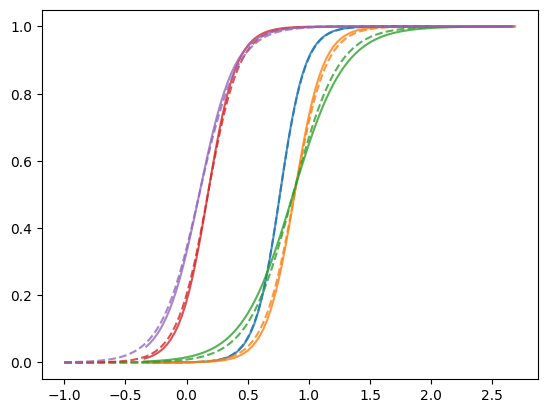

In [3]:
fbm_model = experiment.training_plan().model()
final_params = experiment.aggregated_params()[N_ROUNDS - 1]["params"]

check_model_fit(
    fbm_model.get_k_values(final_params["log_k_values"]).data.numpy(),
    final_params["x0_values"].data.numpy(),
    final_params["time_shifts"].data.numpy(),
    align_x=True,
)

Epoch [100/700], Loss: 258.8777
Epoch [200/700], Loss: -14.4468
Epoch [300/700], Loss: -250.7728
Epoch [400/700], Loss: -412.7839
Epoch [500/700], Loss: -465.9561
Epoch [600/700], Loss: -471.9309
Epoch [700/700], Loss: -472.1648
===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.739 8.653 4.771 8.598 6.938]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[ 0.174  0.285  0.306 -0.395 -0.478]
===== x value differences =====
[0.59  0.598 0.564 0.569 0.581]
===== time shifts =====
[0.927 0.309 0.202 0.303 0.48  0.673 0.743 0.32  0.668 0.303 0.308 0.344
 0.874 0.778 0.841 0.018 0.109 0.49  0.203 0.616 0.945 0.488 0.045 0.791
 0.162 0.71  0.653 0.769 0.485 0.157 0.673 0.041 0.924 0.741 0.062 0.503
 0.184 0.527 0.861 0.467 0.445 0.484 0.625 0.826 0.877 0.422 0.579 0.685
 0.836 0.307]
[ 0.336 -0.259 -0.406 -0.337 -0.161  0.073  0.176 -0.304  0.063 -0.3
 -0.297 -0.28   0.268  0.224  0.235 -0.604 -0.429 -0.142 -0.395 -0.009
  0.367 -0.068 -0.51   0.165 -0.435  0.15   0.075  0.127 -0.1

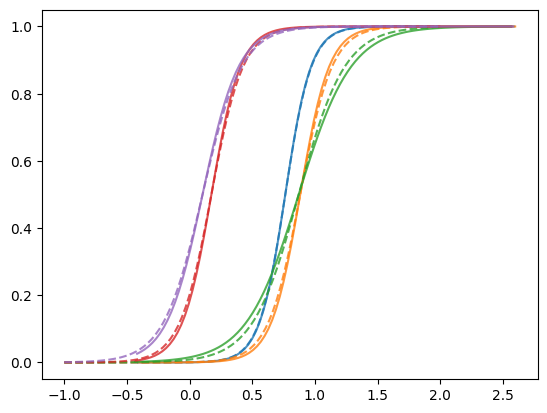

In [4]:
from fl_prog.model import LogisticRegressionModelWithShift
import torch
import torch.optim as optim

model = LogisticRegressionModelWithShift(
    len(set(df["subject"])), n_features=n_biomarkers
)

# Define the optimizer
optimizer = optim.Adam(list(model.parameters()), lr=LEARNING_RATE)

# Optimization loop
num_epochs = (
    N_UPDATES * N_ROUNDS
)  # Increased epochs for potentially harder optimization
for epoch in range(num_epochs):
    # Forward pass
    # Pass both timestamps and sample indices to the model
    model_predictions = model(
        torch.tensor(df["timepoint"]), torch.tensor(df["subject"])
    )
    loss = model.get_loss(
        model_predictions,
        torch.tensor(
            df[[f"biomarker_{i}" for i in range(n_biomarkers)]].values,
        ),
    )

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss periodically
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

check_model_fit(
    model.get_k_values(model.log_k_values).data.numpy(),
    model.x0_values.data.numpy(),
    model.time_shifts.data.numpy(),
    align_x=True,
)